In [2]:
# %%bash
# Install dependencies (run once)
!pip install torch gymnasium wandb numpy matplotlib gymnasium[other] pygame moviepy nbformat >/dev/null 2>&1 || true


The system cannot find the path specified.
'true' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# %%
# Imports and device setup
import os
import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import wandb
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# %%
# Optional: WandB setup (comment out if you don't want to use WandB)
try:
    wandb.login()
    wandb.init(project="RL_Assignment2_DQN_DDQN", name="DQN_vs_DDQN_Experiments", reinit=True)
except Exception as e:
    print("WandB init failed or skipped:", e)

In [5]:
# %%
# Q-network definition
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_units=128):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, action_size)

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float().to(device)
        if x.dim() == 1:
            x = x.unsqueeze(0)
            squeeze_out = True
        else:
            squeeze_out = False
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        out = self.fc3(x)
        if squeeze_out:
            return out.squeeze(0)
        return out

In [6]:
# %%
# Replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

In [ ]:
# %%
# DQNAgent and DDQNAgent definitions
class DQNAgent:
    def __init__(self, state_size, action_size, config):
        self.state_size = state_size
        self.action_size = action_size

        # Hyperparameters
        self.gamma = config.get("gamma", 0.99)
        self.epsilon = config.get("epsilon_start", 1.0)
        self.epsilon_min = config.get("epsilon_min", 0.01)
        self.epsilon_decay = config.get("epsilon_decay", 0.995)
        self.lr = config.get("lr", 1e-3)

        # Networks (on device)
        self.q_network = QNetwork(state_size, action_size).to(device)
        self.target_network = QNetwork(state_size, action_size).to(device)
        self.update_target()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.lr)
        self.memory = ReplayBuffer(config.get("memory_size", 50000))
        self.batch_size = config.get("batch_size", 64)

    def update_target(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)
        with torch.no_grad():
            st = torch.from_numpy(np.array(state)).float().to(device)
            q_values = self.q_network(st)
        return int(torch.argmax(q_values).item())

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return None

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.FloatTensor(states).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_network(next_states).max(1)[0]
        targets = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, targets.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        return loss.item()

    def save(self, path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save(self.q_network.state_dict(), path)

    def load(self, path, map_location=None):
        mp = map_location if map_location is not None else device
        self.q_network.load_state_dict(torch.load(path, map_location=mp))
        self.update_target()
        self.q_network.to(device)
        self.target_network.to(device)


class DDQNAgent(DQNAgent):
    def replay(self):
        if len(self.memory) < self.batch_size:
            return None

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.FloatTensor(states).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_actions = self.q_network(next_states).argmax(1)
        next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        targets = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, targets.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        return loss.item()

In [8]:
# %%
# Describe environment utility
def describe_env(env):
    obs_space = env.observation_space
    act_space = env.action_space

    details = {}
    details["observation_space"] = str(obs_space)
    details["observation_shape"] = getattr(obs_space, "shape", None)
    details["action_space"] = str(act_space)

    if isinstance(act_space, gym.spaces.Discrete):
        details["action_type"] = "discrete"
        details["action_n"] = act_space.n
    elif isinstance(act_space, gym.spaces.Box):
        details["action_type"] = "continuous"
        details["action_low"] = act_space.low
        details["action_high"] = act_space.high
        details["action_shape"] = act_space.shape
    else:
        details["action_type"] = "other"

    print("=== Environment description ===")
    for k, v in details.items():
        print(f"{k}: {v}")
    print("===============================")
    return details

In [9]:
# %%
# Train function (keeps training-only logic)
def train_agent(env_name, agent_type="DQN", episodes=300, seed=0, save_model=True, verbose=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    env = gym.make(env_name)
    env_details = describe_env(env)

    if isinstance(env.action_space, gym.spaces.Box):
        action_size = 5
        actions_list = np.linspace(env.action_space.low[0], env.action_space.high[0], action_size)
    else:
        action_size = env.action_space.n
        actions_list = np.arange(action_size)

    state_size = env.observation_space.shape[0]
    config = {
        "gamma": 0.99,
        "epsilon_start": 1.0,
        "epsilon_min": 0.01,
        "epsilon_decay": 0.995,
        "lr": 1e-3,
        "memory_size": 50000,
        "batch_size": 64
    }

    try:
        wandb.config.update({
            "env_name": env_name,
            "env_type": env_details["action_type"],
            "obs_shape": env_details["observation_shape"],
            "action_size_used": int(action_size),
        }, allow_val_change=True)
    except Exception:
        pass

    agent = DQNAgent(state_size, action_size, config) if agent_type == "DQN" else DDQNAgent(state_size, action_size, config)
    rewards_list = []

    for ep in range(episodes):
        state, _ = env.reset(seed=seed + ep)
        total_reward = 0
        done = False

        while not done:
            action_idx = agent.act(state)
            action = actions_list[action_idx]
            if isinstance(env.action_space, gym.spaces.Box):
                action_to_env = np.array([action], dtype=env.action_space.dtype)
            else:
                action_to_env = int(action)

            next_state, reward, terminated, truncated, _ = env.step(action_to_env)
            done = terminated or truncated

            agent.remember(state, action_idx, reward, next_state, done)
            loss = agent.replay()
            state = next_state
            total_reward += reward

        agent.update_target()
        rewards_list.append(total_reward)
        try:
            wandb.log({f"{agent_type}/{env_name}/reward": total_reward, f"{agent_type}/{env_name}/epsilon": agent.epsilon})
        except Exception:
            pass

        if verbose and ((ep + 1) % 10 == 0 or ep == 0 or ep == episodes - 1):
            print(f"{agent_type} | {env_name} | Ep {ep+1}/{episodes} | Reward: {total_reward:.2f} | Eps: {agent.epsilon:.3f}")

    model_path = None
    if save_model:
        os.makedirs("models", exist_ok=True)
        model_path = f"models/{env_name}_{agent_type}.pth"
        agent.save(model_path)
        print(f"Saved model to: {model_path}")

    env.close()
    return agent, rewards_list, {"env_details": env_details, "actions_list": actions_list, "model_path": model_path}

In [10]:
# %%
# Evaluate and record function
def evaluate_and_record(agent, env_name, actions_list, agent_type="DQN", episodes=100, num_record_episodes=3, seed=42):
    video_folder = f"videos/{env_name}/{agent_type}"
    os.makedirs(video_folder, exist_ok=True)

    try:
        base_env = gym.make(env_name, render_mode="rgb_array")
    except TypeError:
        base_env = gym.make(env_name)

    # Record only the last `num_record_episodes` episodes
    episode_trigger = lambda ep: ep >= (episodes - num_record_episodes)

    env = RecordVideo(base_env, video_folder=video_folder, episode_trigger=episode_trigger)

    details = describe_env(base_env)
    try:
        wandb.log({f"{agent_type}/{env_name}/env_description": str(details)})
    except Exception:
        pass

    # during evaluation prefer deterministic policy (set epsilon to epsilon_min temporarily)
    old_epsilon = getattr(agent, 'epsilon', None)
    if old_epsilon is not None:
        agent.epsilon = getattr(agent, 'epsilon_min', 0.0)

    all_episode_rewards = []
    import time
    episode_times = []

    for ep in range(episodes):
        state, _ = env.reset(seed=seed + ep)
        done = False
        total_reward = 0
        step = 0
        start_t = time.time()

        while not done:
            action_idx = agent.act(state)
            action = actions_list[action_idx]
            if isinstance(base_env.action_space, gym.spaces.Box):
                action_to_env = np.array([action], dtype=base_env.action_space.dtype)
            else:
                action_to_env = int(action)
            next_state, reward, terminated, truncated, _ = env.step(action_to_env)
            done = terminated or truncated
            state = next_state
            total_reward += reward
            step += 1

        end_t = time.time()
        ep_time = end_t - start_t
        episode_times.append(ep_time)
        all_episode_rewards.append(total_reward)
        print(f"[VIDEO] {agent_type} | {env_name} | Ep {ep+1}/{episodes} | Reward: {total_reward:.2f} | Steps: {step} | Time: {ep_time:.3f}s")

    # restore epsilon
    if old_epsilon is not None:
        agent.epsilon = old_epsilon

    env.close()
    vids = sorted([os.path.join(video_folder, f) for f in os.listdir(video_folder) if f.endswith(".mp4")])
    print(f"Saved {len(vids)} videos to {video_folder}")

    for i, v in enumerate(vids):
        try:
            wandb.log({f"{agent_type}/{env_name}/video_{i}": wandb.Video(v, fps=30, format="mp4")})
        except Exception as e:
            print("WandB video upload failed:", e)

    try:
        wandb.log({f"{agent_type}/{env_name}/eval_episode_times": episode_times})
    except Exception:
        pass

    return all_episode_rewards, vids, episode_times

In [11]:
# %%
# TRAINING (run this cell to train models; skip if you already have saved models)
envs = ["CartPole-v1", "Acrobot-v1", "MountainCar-v0", "Pendulum-v1"]
results = {}

for env_name in envs:
    print(f"\n{'='*60}\nTRAINING {env_name} with DQN\n{'='*60}")
    dqn_agent, dqn_rewards, dqn_meta = train_agent(env_name, "DQN", episodes=100, seed=0, save_model=True, verbose=True)

    print(f"\n{'='*60}\nTRAINING {env_name} with DDQN\n{'='*60}")
    ddqn_agent, ddqn_rewards, ddqn_meta = train_agent(env_name, "DDQN", episodes=100, seed=0, save_model=True, verbose=True)

    results[env_name] = {
        "DQN": {"agent": dqn_agent, "rewards": dqn_rewards, "meta": dqn_meta},
        "DDQN": {"agent": ddqn_agent, "rewards": ddqn_rewards, "meta": ddqn_meta}
    }


TRAINING CartPole-v1 with DQN
=== Environment description ===
observation_space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
observation_shape: (4,)
action_space: Discrete(2)
action_type: discrete
action_n: 2
DQN | CartPole-v1 | Ep 1/100 | Reward: 18.00 | Eps: 1.000
DQN | CartPole-v1 | Ep 10/100 | Reward: 12.00 | Eps: 0.554
DQN | CartPole-v1 | Ep 20/100 | Reward: 109.00 | Eps: 0.075
DQN | CartPole-v1 | Ep 30/100 | Reward: 280.00 | Eps: 0.010
DQN | CartPole-v1 | Ep 40/100 | Reward: 325.00 | Eps: 0.010
DQN | CartPole-v1 | Ep 50/100 | Reward: 260.00 | Eps: 0.010
DQN | CartPole-v1 | Ep 60/100 | Reward: 280.00 | Eps: 0.010
DQN | CartPole-v1 | Ep 70/100 | Reward: 229.00 | Eps: 0.010
DQN | CartPole-v1 | Ep 80/100 | Reward: 248.00 | Eps: 0.010
DQN | CartPole-v1 | Ep 90/100 | Reward: 500.00 | Eps: 0.010
DQN | CartPole-v1 | Ep 100/100 | Reward: 354.00 | Eps: 0.010
Saved model to: models/CartPole-v1_DQN.pth

TRAINING CartPo

In [12]:
# %%
# EVALUATION & RECORDING (separate cell so you don't need to retrain)
# This cell loads saved models from ./models/ and evaluates them, recording ONLY the last 3 episodes.
envs = ["CartPole-v1", "Acrobot-v1", "MountainCar-v0", "Pendulum-v1"]
eval_results = {}

for env_name in envs:
    eval_results[env_name] = {}
    for agent_type in ["DQN", "DDQN"]:
        model_path = f"models/{env_name}_{agent_type}.pth"
        if not os.path.exists(model_path):
            print(f"Model not found: {model_path} -- skip evaluation for {env_name} {agent_type}")
            continue

        # Create agent with same config and load weights
        # We need the state_size and action_size of the environment
        tmp_env = gym.make(env_name)
        if isinstance(tmp_env.action_space, gym.spaces.Box):
            action_size = 5
            actions_list = np.linspace(tmp_env.action_space.low[0], tmp_env.action_space.high[0], action_size)
        else:
            action_size = tmp_env.action_space.n
            actions_list = np.arange(action_size)
        state_size = tmp_env.observation_space.shape[0]
        tmp_env.close()

        config = {
            "gamma": 0.99,
            "epsilon_start": 0.01,
            "epsilon_min": 0.01,
            "epsilon_decay": 0.995,
            "lr": 1e-3,
            "memory_size": 50000,
            "batch_size": 64
        }

        agent = DQNAgent(state_size, action_size, config) if agent_type == "DQN" else DDQNAgent(state_size, action_size, config)
        agent.load(model_path, map_location=device)
        print(f"Loaded model: {model_path}")

        # Evaluate and record last 3 episodes
        ep_count = 100
        all_rewards, vids, times = evaluate_and_record(agent, env_name, actions_list, agent_type=agent_type, episodes=ep_count, num_record_episodes=3, seed=42)
        eval_results[env_name][agent_type] = {"rewards": all_rewards, "videos": vids, "times": times}

Loaded model: models/CartPole-v1_DQN.pth
=== Environment description ===
observation_space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
observation_shape: (4,)
action_space: Discrete(2)
action_type: discrete
action_n: 2


C:\Users\user\AppData\Local\Temp\ipykernel_2956\176182743.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.q_network.load_state_dict(torch.load(path, map_location=m

[VIDEO] DQN | CartPole-v1 | Ep 1/100 | Reward: 358.00 | Steps: 358 | Time: 0.159s
[VIDEO] DQN | CartPole-v1 | Ep 2/100 | Reward: 404.00 | Steps: 404 | Time: 0.187s
[VIDEO] DQN | CartPole-v1 | Ep 3/100 | Reward: 364.00 | Steps: 364 | Time: 0.228s
[VIDEO] DQN | CartPole-v1 | Ep 4/100 | Reward: 370.00 | Steps: 370 | Time: 0.253s
[VIDEO] DQN | CartPole-v1 | Ep 5/100 | Reward: 313.00 | Steps: 313 | Time: 0.234s
[VIDEO] DQN | CartPole-v1 | Ep 6/100 | Reward: 362.00 | Steps: 362 | Time: 0.221s
[VIDEO] DQN | CartPole-v1 | Ep 7/100 | Reward: 332.00 | Steps: 332 | Time: 0.146s
[VIDEO] DQN | CartPole-v1 | Ep 8/100 | Reward: 410.00 | Steps: 410 | Time: 0.185s
[VIDEO] DQN | CartPole-v1 | Ep 9/100 | Reward: 437.00 | Steps: 437 | Time: 0.193s
[VIDEO] DQN | CartPole-v1 | Ep 10/100 | Reward: 243.00 | Steps: 243 | Time: 0.109s
[VIDEO] DQN | CartPole-v1 | Ep 11/100 | Reward: 375.00 | Steps: 375 | Time: 0.165s
[VIDEO] DQN | CartPole-v1 | Ep 12/100 | Reward: 412.00 | Steps: 412 | Time: 0.326s
[VIDEO] DQN |

wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


Saved 3 videos to videos/CartPole-v1/DQN


wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
C:\Users\user\AppData\Local\Temp\ipykernel_2956\176182743.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_

Loaded model: models/CartPole-v1_DDQN.pth
=== Environment description ===
observation_space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
observation_shape: (4,)
action_space: Discrete(2)
action_type: discrete
action_n: 2
[VIDEO] DDQN | CartPole-v1 | Ep 1/100 | Reward: 202.00 | Steps: 202 | Time: 0.095s
[VIDEO] DDQN | CartPole-v1 | Ep 2/100 | Reward: 192.00 | Steps: 192 | Time: 0.091s
[VIDEO] DDQN | CartPole-v1 | Ep 3/100 | Reward: 190.00 | Steps: 190 | Time: 0.178s
[VIDEO] DDQN | CartPole-v1 | Ep 4/100 | Reward: 205.00 | Steps: 205 | Time: 0.097s
[VIDEO] DDQN | CartPole-v1 | Ep 5/100 | Reward: 192.00 | Steps: 192 | Time: 0.086s
[VIDEO] DDQN | CartPole-v1 | Ep 6/100 | Reward: 206.00 | Steps: 206 | Time: 0.095s
[VIDEO] DDQN | CartPole-v1 | Ep 7/100 | Reward: 201.00 | Steps: 201 | Time: 0.093s
[VIDEO] DDQN | CartPole-v1 | Ep 8/100 | Reward: 197.00 | Steps: 197 | Time: 0.135s
[VIDEO] DDQN | CartPole-v1 | Ep 9/100 | Re

wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


Saved 3 videos to videos/CartPole-v1/DDQN
Loaded model: models/Acrobot-v1_DQN.pth
=== Environment description ===
observation_space: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
observation_shape: (6,)
action_space: Discrete(3)
action_type: discrete
action_n: 3
[VIDEO] DQN | Acrobot-v1 | Ep 1/100 | Reward: -99.00 | Steps: 100 | Time: 0.052s
[VIDEO] DQN | Acrobot-v1 | Ep 2/100 | Reward: -74.00 | Steps: 75 | Time: 0.055s


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at e:\RL\RL-Lab2(FinalVersion)\videos\Acrobot-v1\DQN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[VIDEO] DQN | Acrobot-v1 | Ep 3/100 | Reward: -105.00 | Steps: 106 | Time: 0.061s
[VIDEO] DQN | Acrobot-v1 | Ep 4/100 | Reward: -82.00 | Steps: 83 | Time: 0.060s
[VIDEO] DQN | Acrobot-v1 | Ep 5/100 | Reward: -95.00 | Steps: 96 | Time: 0.050s
[VIDEO] DQN | Acrobot-v1 | Ep 6/100 | Reward: -96.00 | Steps: 97 | Time: 0.059s
[VIDEO] DQN | Acrobot-v1 | Ep 7/100 | Reward: -112.00 | Steps: 113 | Time: 0.062s
[VIDEO] DQN | Acrobot-v1 | Ep 8/100 | Reward: -233.00 | Steps: 234 | Time: 0.129s
[VIDEO] DQN | Acrobot-v1 | Ep 9/100 | Reward: -110.00 | Steps: 111 | Time: 0.060s
[VIDEO] DQN | Acrobot-v1 | Ep 10/100 | Reward: -110.00 | Steps: 111 | Time: 0.064s
[VIDEO] DQN | Acrobot-v1 | Ep 11/100 | Reward: -88.00 | Steps: 89 | Time: 0.051s
[VIDEO] DQN | Acrobot-v1 | Ep 12/100 | Reward: -171.00 | Steps: 172 | Time: 0.101s
[VIDEO] DQN | Acrobot-v1 | Ep 13/100 | Reward: -118.00 | Steps: 119 | Time: 0.063s
[VIDEO] DQN | Acrobot-v1 | Ep 14/100 | Reward: -89.00 | Steps: 90 | Time: 0.050s
[VIDEO] DQN | Acrobot

wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


Saved 3 videos to videos/Acrobot-v1/DQN
Loaded model: models/Acrobot-v1_DDQN.pth
=== Environment description ===
observation_space: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
observation_shape: (6,)
action_space: Discrete(3)
action_type: discrete
action_n: 3
[VIDEO] DDQN | Acrobot-v1 | Ep 1/100 | Reward: -76.00 | Steps: 77 | Time: 0.041s
[VIDEO] DDQN | Acrobot-v1 | Ep 2/100 | Reward: -89.00 | Steps: 90 | Time: 0.050s


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at e:\RL\RL-Lab2(FinalVersion)\videos\Acrobot-v1\DDQN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[VIDEO] DDQN | Acrobot-v1 | Ep 3/100 | Reward: -117.00 | Steps: 118 | Time: 0.065s
[VIDEO] DDQN | Acrobot-v1 | Ep 4/100 | Reward: -79.00 | Steps: 80 | Time: 0.051s
[VIDEO] DDQN | Acrobot-v1 | Ep 5/100 | Reward: -80.00 | Steps: 81 | Time: 0.048s
[VIDEO] DDQN | Acrobot-v1 | Ep 6/100 | Reward: -99.00 | Steps: 100 | Time: 0.055s
[VIDEO] DDQN | Acrobot-v1 | Ep 7/100 | Reward: -130.00 | Steps: 131 | Time: 0.071s
[VIDEO] DDQN | Acrobot-v1 | Ep 8/100 | Reward: -107.00 | Steps: 108 | Time: 0.059s
[VIDEO] DDQN | Acrobot-v1 | Ep 9/100 | Reward: -87.00 | Steps: 88 | Time: 0.046s
[VIDEO] DDQN | Acrobot-v1 | Ep 10/100 | Reward: -95.00 | Steps: 96 | Time: 0.048s
[VIDEO] DDQN | Acrobot-v1 | Ep 11/100 | Reward: -86.00 | Steps: 87 | Time: 0.047s
[VIDEO] DDQN | Acrobot-v1 | Ep 12/100 | Reward: -114.00 | Steps: 115 | Time: 0.062s
[VIDEO] DDQN | Acrobot-v1 | Ep 13/100 | Reward: -92.00 | Steps: 93 | Time: 0.049s
[VIDEO] DDQN | Acrobot-v1 | Ep 14/100 | Reward: -82.00 | Steps: 83 | Time: 0.046s
[VIDEO] DDQN |

wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


Saved 3 videos to videos/Acrobot-v1/DDQN
Loaded model: models/MountainCar-v0_DQN.pth
=== Environment description ===
observation_space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation_shape: (2,)
action_space: Discrete(3)
action_type: discrete
action_n: 3
[VIDEO] DQN | MountainCar-v0 | Ep 1/100 | Reward: -200.00 | Steps: 200 | Time: 0.093s


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at e:\RL\RL-Lab2(FinalVersion)\videos\MountainCar-v0\DQN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[VIDEO] DQN | MountainCar-v0 | Ep 2/100 | Reward: -200.00 | Steps: 200 | Time: 0.096s
[VIDEO] DQN | MountainCar-v0 | Ep 3/100 | Reward: -200.00 | Steps: 200 | Time: 0.096s
[VIDEO] DQN | MountainCar-v0 | Ep 4/100 | Reward: -200.00 | Steps: 200 | Time: 0.091s
[VIDEO] DQN | MountainCar-v0 | Ep 5/100 | Reward: -200.00 | Steps: 200 | Time: 0.089s
[VIDEO] DQN | MountainCar-v0 | Ep 6/100 | Reward: -200.00 | Steps: 200 | Time: 0.089s
[VIDEO] DQN | MountainCar-v0 | Ep 7/100 | Reward: -200.00 | Steps: 200 | Time: 0.091s
[VIDEO] DQN | MountainCar-v0 | Ep 8/100 | Reward: -200.00 | Steps: 200 | Time: 0.092s
[VIDEO] DQN | MountainCar-v0 | Ep 9/100 | Reward: -200.00 | Steps: 200 | Time: 0.089s
[VIDEO] DQN | MountainCar-v0 | Ep 10/100 | Reward: -200.00 | Steps: 200 | Time: 0.090s
[VIDEO] DQN | MountainCar-v0 | Ep 11/100 | Reward: -200.00 | Steps: 200 | Time: 0.092s
[VIDEO] DQN | MountainCar-v0 | Ep 12/100 | Reward: -200.00 | Steps: 200 | Time: 0.105s
[VIDEO] DQN | MountainCar-v0 | Ep 13/100 | Reward: 

wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


Saved 3 videos to videos/MountainCar-v0/DQN
Loaded model: models/MountainCar-v0_DDQN.pth
=== Environment description ===
observation_space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation_shape: (2,)
action_space: Discrete(3)
action_type: discrete
action_n: 3
[VIDEO] DDQN | MountainCar-v0 | Ep 1/100 | Reward: -200.00 | Steps: 200 | Time: 0.102s


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at e:\RL\RL-Lab2(FinalVersion)\videos\MountainCar-v0\DDQN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[VIDEO] DDQN | MountainCar-v0 | Ep 2/100 | Reward: -200.00 | Steps: 200 | Time: 0.100s
[VIDEO] DDQN | MountainCar-v0 | Ep 3/100 | Reward: -200.00 | Steps: 200 | Time: 0.102s
[VIDEO] DDQN | MountainCar-v0 | Ep 4/100 | Reward: -200.00 | Steps: 200 | Time: 0.093s
[VIDEO] DDQN | MountainCar-v0 | Ep 5/100 | Reward: -200.00 | Steps: 200 | Time: 0.090s
[VIDEO] DDQN | MountainCar-v0 | Ep 6/100 | Reward: -200.00 | Steps: 200 | Time: 0.091s
[VIDEO] DDQN | MountainCar-v0 | Ep 7/100 | Reward: -200.00 | Steps: 200 | Time: 0.166s
[VIDEO] DDQN | MountainCar-v0 | Ep 8/100 | Reward: -200.00 | Steps: 200 | Time: 0.096s
[VIDEO] DDQN | MountainCar-v0 | Ep 9/100 | Reward: -200.00 | Steps: 200 | Time: 0.095s
[VIDEO] DDQN | MountainCar-v0 | Ep 10/100 | Reward: -200.00 | Steps: 200 | Time: 0.112s
[VIDEO] DDQN | MountainCar-v0 | Ep 11/100 | Reward: -200.00 | Steps: 200 | Time: 0.096s
[VIDEO] DDQN | MountainCar-v0 | Ep 12/100 | Reward: -200.00 | Steps: 200 | Time: 0.123s
[VIDEO] DDQN | MountainCar-v0 | Ep 13/10

wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


Saved 3 videos to videos/MountainCar-v0/DDQN
Loaded model: models/Pendulum-v1_DQN.pth
=== Environment description ===
observation_space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
observation_shape: (3,)
action_space: Box(-2.0, 2.0, (1,), float32)
action_type: continuous
action_low: [-2.]
action_high: [2.]
action_shape: (1,)
[VIDEO] DQN | Pendulum-v1 | Ep 1/100 | Reward: -119.89 | Steps: 200 | Time: 0.099s


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at e:\RL\RL-Lab2(FinalVersion)\videos\Pendulum-v1\DQN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[VIDEO] DQN | Pendulum-v1 | Ep 2/100 | Reward: -125.94 | Steps: 200 | Time: 0.096s
[VIDEO] DQN | Pendulum-v1 | Ep 3/100 | Reward: -235.21 | Steps: 200 | Time: 0.096s
[VIDEO] DQN | Pendulum-v1 | Ep 4/100 | Reward: -126.73 | Steps: 200 | Time: 0.123s
[VIDEO] DQN | Pendulum-v1 | Ep 5/100 | Reward: -268.41 | Steps: 200 | Time: 0.116s
[VIDEO] DQN | Pendulum-v1 | Ep 6/100 | Reward: -116.64 | Steps: 200 | Time: 0.094s
[VIDEO] DQN | Pendulum-v1 | Ep 7/100 | Reward: -125.73 | Steps: 200 | Time: 0.094s
[VIDEO] DQN | Pendulum-v1 | Ep 8/100 | Reward: -123.53 | Steps: 200 | Time: 0.094s
[VIDEO] DQN | Pendulum-v1 | Ep 9/100 | Reward: -121.32 | Steps: 200 | Time: 0.096s
[VIDEO] DQN | Pendulum-v1 | Ep 10/100 | Reward: -307.78 | Steps: 200 | Time: 0.094s
[VIDEO] DQN | Pendulum-v1 | Ep 11/100 | Reward: -123.86 | Steps: 200 | Time: 0.096s
[VIDEO] DQN | Pendulum-v1 | Ep 12/100 | Reward: -346.61 | Steps: 200 | Time: 0.100s
[VIDEO] DQN | Pendulum-v1 | Ep 13/100 | Reward: -118.65 | Steps: 200 | Time: 0.097s


wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


Saved 3 videos to videos/Pendulum-v1/DQN
Loaded model: models/Pendulum-v1_DDQN.pth
=== Environment description ===
observation_space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
observation_shape: (3,)
action_space: Box(-2.0, 2.0, (1,), float32)
action_type: continuous
action_low: [-2.]
action_high: [2.]
action_shape: (1,)
[VIDEO] DDQN | Pendulum-v1 | Ep 1/100 | Reward: -119.68 | Steps: 200 | Time: 0.118s


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at e:\RL\RL-Lab2(FinalVersion)\videos\Pendulum-v1\DDQN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[VIDEO] DDQN | Pendulum-v1 | Ep 2/100 | Reward: -130.56 | Steps: 200 | Time: 0.098s
[VIDEO] DDQN | Pendulum-v1 | Ep 3/100 | Reward: -240.46 | Steps: 200 | Time: 0.098s
[VIDEO] DDQN | Pendulum-v1 | Ep 4/100 | Reward: -130.94 | Steps: 200 | Time: 0.096s
[VIDEO] DDQN | Pendulum-v1 | Ep 5/100 | Reward: -253.55 | Steps: 200 | Time: 0.095s
[VIDEO] DDQN | Pendulum-v1 | Ep 6/100 | Reward: -119.48 | Steps: 200 | Time: 0.093s
[VIDEO] DDQN | Pendulum-v1 | Ep 7/100 | Reward: -125.68 | Steps: 200 | Time: 0.094s
[VIDEO] DDQN | Pendulum-v1 | Ep 8/100 | Reward: -125.37 | Steps: 200 | Time: 0.105s
[VIDEO] DDQN | Pendulum-v1 | Ep 9/100 | Reward: -116.28 | Steps: 200 | Time: 0.099s
[VIDEO] DDQN | Pendulum-v1 | Ep 10/100 | Reward: -253.31 | Steps: 200 | Time: 0.100s
[VIDEO] DDQN | Pendulum-v1 | Ep 11/100 | Reward: -128.53 | Steps: 200 | Time: 0.113s
[VIDEO] DDQN | Pendulum-v1 | Ep 12/100 | Reward: -363.47 | Steps: 200 | Time: 0.104s
[VIDEO] DDQN | Pendulum-v1 | Ep 13/100 | Reward: -122.10 | Steps: 200 | T

wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


Saved 3 videos to videos/Pendulum-v1/DDQN


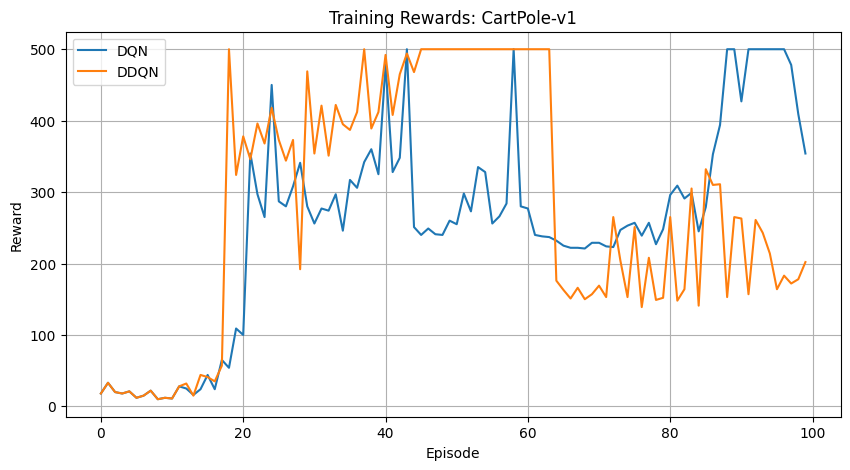

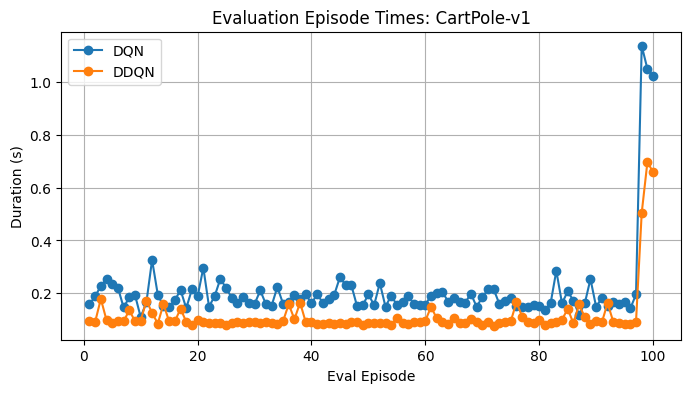

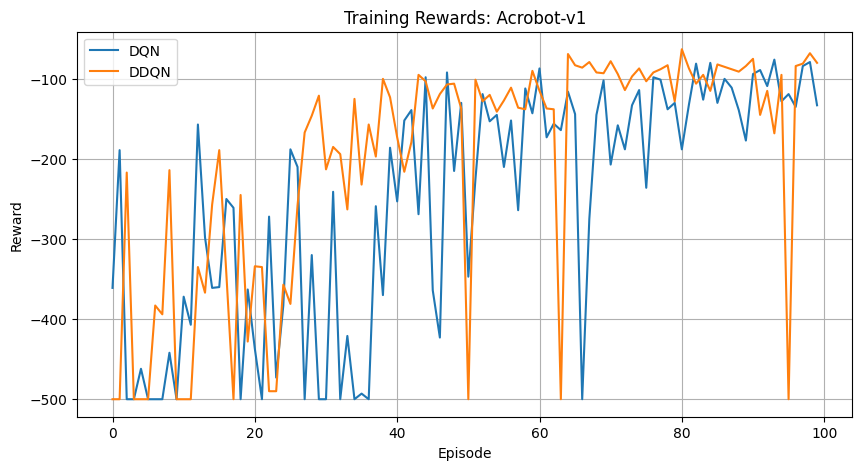

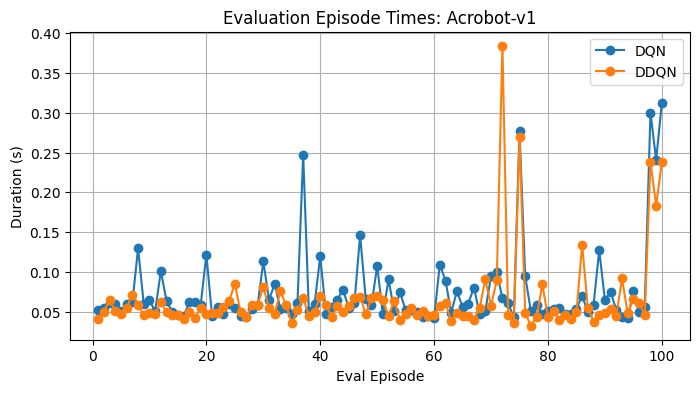

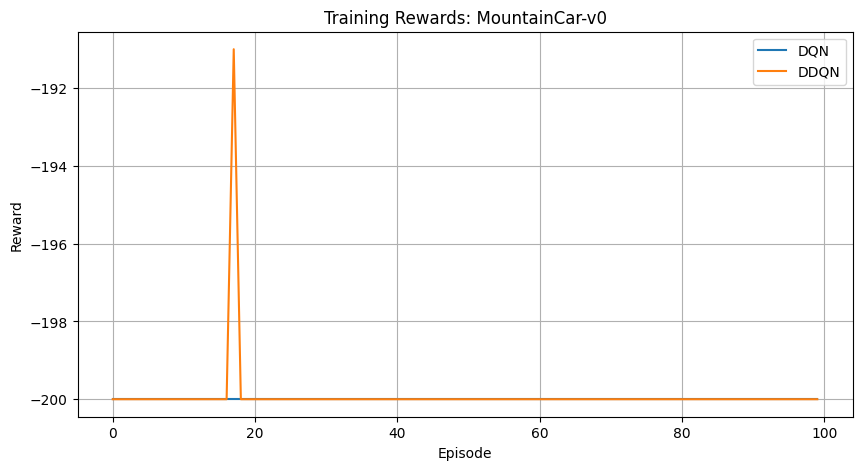

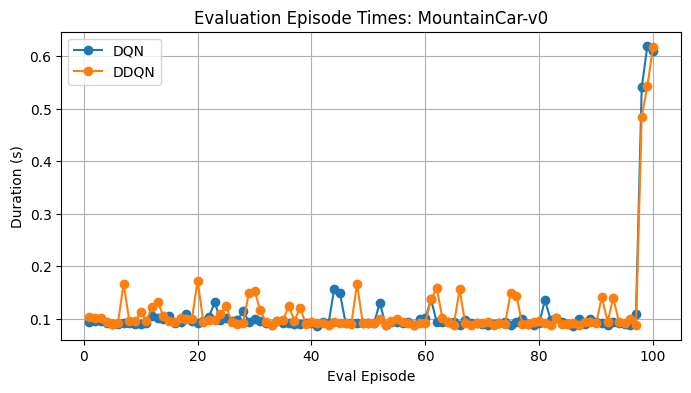

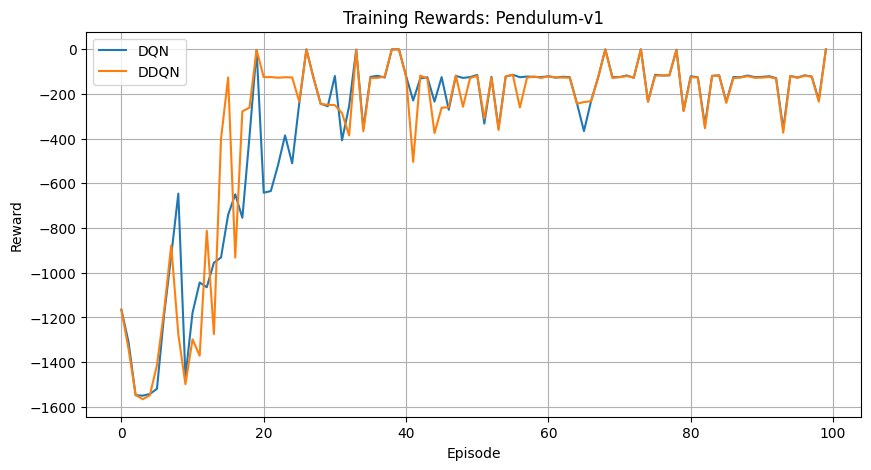

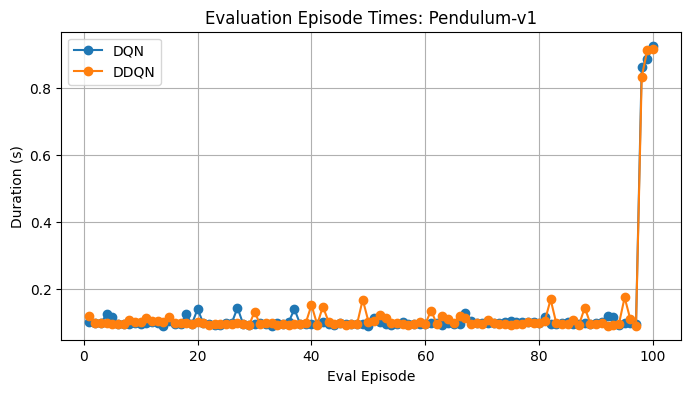

In [13]:
# %%
# Plot training rewards (if available) and evaluation times
def plot_rewards(env_name, results_dict):
    plt.figure(figsize=(10,5))
    plt.title(f"Training Rewards: {env_name}")
    if results_dict.get("DQN") and len(results_dict["DQN"].get("rewards", [])) > 0:
        plt.plot(results_dict["DQN"]["rewards"], label="DQN")
    if results_dict.get("DDQN") and len(results_dict["DDQN"].get("rewards", [])) > 0:
        plt.plot(results_dict["DDQN"]["rewards"], label="DDQN")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_episode_times(env_name, results_dict):
    plt.figure(figsize=(8,4))
    plt.title(f"Evaluation Episode Times: {env_name}")
    dqn_times = results_dict.get("DQN", {}).get("times", []) or results_dict.get("DQN", {}).get("eval_times", [])
    ddqn_times = results_dict.get("DDQN", {}).get("times", []) or results_dict.get("DDQN", {}).get("eval_times", [])
    if dqn_times:
        plt.plot(range(1, len(dqn_times)+1), dqn_times, marker='o', label="DQN")
    if ddqn_times:
        plt.plot(range(1, len(ddqn_times)+1), ddqn_times, marker='o', label="DDQN")
    plt.xlabel("Eval Episode")
    plt.ylabel("Duration (s)")
    plt.legend()
    plt.grid(True)
    plt.show()

# If 'results' from training cell exists, plot it; otherwise plot eval_results summaries
try:
    for env_name in ["CartPole-v1", "Acrobot-v1", "MountainCar-v0", "Pendulum-v1"]:
        if 'results' in globals() and env_name in results:
            plot_rewards(env_name, results[env_name])
        if 'eval_results' in globals() and env_name in eval_results:
            # wrap eval_results to match expected structure for times plotting
            r = {}
            if 'DQN' in eval_results[env_name]:
                r['DQN'] = {'times': eval_results[env_name]['DQN'].get('times', eval_results[env_name]['DQN'].get('eval_times', []))}
            if 'DDQN' in eval_results[env_name]:
                r['DDQN'] = {'times': eval_results[env_name]['DDQN'].get('times', eval_results[env_name]['DDQN'].get('eval_times', []))}
            plot_episode_times(env_name, r)
except Exception as e:
    print('Plotting skipped or failed:', e)

In [14]:
# %%
print("Models saved in ./models/")
print("Videos saved in ./videos/<ENV_NAME>/<AGENT_TYPE>/")
print("To download this notebook, use the link provided in the assistant response.")

Models saved in ./models/
Videos saved in ./videos/<ENV_NAME>/<AGENT_TYPE>/
To download this notebook, use the link provided in the assistant response.
